In [29]:
## Imports
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import os
import numpy as np
import pandas as pd




In [69]:
class CustomDatasetFromDepthImages(Dataset):
    def __init__(self, csv_path, img_path):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[1:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[1:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index) - 2 

        self.img_path = img_path

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.img_path + '/' + self.image_arr[index]
        # Open image
        img_as_img = np.load(single_image_name)
        goal_np = img_as_img[:2]
        goal_np /= 1000.0
        img_as_img = img_as_img[2:]
        img_as_img /= 10000.0
        # Transform image to tensor
        img_as_tensor = torch.from_numpy(img_as_img.astype('float32'))
        img_as_tensor = torch.unsqueeze(img_as_tensor, 0)
        img_as_tensor = torch.cat(tuple([img_as_tensor for item in range(len(img_as_img))]), 0)
        img_as_tensor = torch.unsqueeze(img_as_tensor, 0)
        
        
        goal_as_tensor = torch.from_numpy(goal_np.astype('float32'))
        goal_as_tensor = torch.unsqueeze(goal_as_tensor, 1)
        goal_as_tensor = torch.unsqueeze(goal_as_tensor, 1)


        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, goal_as_tensor, int(single_image_label))

    def __len__(self):
        return self.data_len
    

In [70]:
DATAPATH = '/home/alex/Documents/datasets/VisualPlanerData/iter_3/out.csv'
DATAPATHIMAGES = '/home/alex/Documents/datasets/VisualPlanerData/iter_3'
custom_dataset =  CustomDatasetFromDepthImages(DATAPATH, DATAPATHIMAGES)
custom_dataset.data_info

,0,1
0,File Name,Label
1,1.npy,1
2,2.npy,1
3,3.npy,1
4,4.npy,1
...,...,...
15932,15933.npy,4
15933,15934.npy,4
15934,15935.npy,4
15935,15936.npy,4


In [71]:
print(custom_dataset[0])
# plt.imshow(image, cmap = 'gray')
# print('Label:', label)

(tensor([[[1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]]), tensor([[[ 0.4561]],

        [[-0.4178]]]), 1)


In [72]:
t = torch.tensor([-100, 100])
t = torch.unsqueeze(t, 1)
t = torch.unsqueeze(t, 1)
t = torch.unsqueeze(t, 0)
# t[0][0][0][0]
t.shape

torch.Size([1, 2, 1, 1])

In [73]:

image_tensor, goal_tensor, label = custom_dataset[0]
print(image_tensor.shape, goal_tensor.shape, label)
print(image_tensor.shape)
m = nn.Conv2d(1, 60, 3, stride=1, padding=1)
# input = torch.randn(20, 16, 50)
output = m(image_tensor)

print(output.shape)

torch.Size([1, 40, 40]) torch.Size([2, 1, 1]) 1
torch.Size([1, 40, 40])
torch.Size([60, 40, 40])


In [74]:

print(image_tensor)
print(torch.max(image_tensor), torch.min(image_tensor))

tensor([[[1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.0690, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])
tensor(1.) tensor(0.0417)


In [75]:
k = 0.8
train_data_len = round(custom_dataset.data_len * k)
validation_data_len = round(custom_dataset.data_len * (1-k))
train_data, validation_data = random_split(custom_dataset, [train_data_len, validation_data_len])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

length of Train Datasets:  12748
length of Validation Datasets:  3187


In [76]:
batch_size = 16

train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

for img, goal, label in train_loader:
    print(img.shape)
    print(goal.shape)
    break

torch.Size([16, 1, 40, 40])
torch.Size([16, 2, 1, 1])


In [52]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

In [62]:
input_size = 42*42
num_classes = 6

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = nn.CrossEntropyLoss()

        self.conv0 = nn.Conv2d(1, 20, 3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(20, 40, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(40, 80, 3, stride=1, padding=1)

        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(82, 150)
        self.linear2 = nn.Linear(150, 100)
        self.linear3 = nn.Linear(100, 50)
        self.linear4 = nn.Linear(50, 25)
        self.linear5 = nn.Linear(25, num_classes)

        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
    
    def forward(self, x, g):
        # print(xb.shape)
        out = self.conv0(x)
        out = self.act(out)
        # print(out.shape)
        out = self.conv1(out)
        out = self.act(out)
        # print(out.shape)
        out = self.conv2(out)
        out = self.act(out)
        # print(out.shape)

        out = self.adaptivepool(out)
        # print(out.shape)
        out = torch.cat((out, g), 1)
        # print(out.shape)

        out = self.flat(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        out = self.act(out)
        out = self.linear3(out)
        out = self.act(out)
        out = self.linear4(out)
        out = self.act(out)
        out = self.linear5(out)
        return(out)
    
    def training_step(self, batch):
        images, goals, labels = batch
        out = self(images, goals) ## Generate predictions
        loss = self.loss_fn(out, labels) ## Calculate the loss
        return(loss)
    
    def validation_step(self, batch):
        images, goals, labels = batch
        out = self(images, goals)
        # labels = F.one_hot(labels, num_classes)
        # out = torch.argmax(out, dim=1) 
        # out = torch.argmax(out, dim=1) 
        # print(out.shape, labels.shape)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return({'val_loss':loss, 'val_acc': acc})
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()
model


MnistModel(
  (loss_fn): CrossEntropyLoss()
  (conv0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=82, out_features=150, bias=True)
  (linear2): Linear(in_features=150, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=50, bias=True)
  (linear4): Linear(in_features=50, out_features=25, bias=True)
  (linear5): Linear(in_features=25, out_features=6, bias=True)
  (act): LeakyReLU(negative_slope=0.2)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [63]:

image_tensor = custom_dataset[100][0]
goal_tensor = custom_dataset[100][1]
print(goal_tensor)
image_tensor = torch.unsqueeze(image_tensor, 0)
goal_tensor = torch.unsqueeze(goal_tensor, 0)
model.forward(image_tensor, goal_tensor).shape


tensor([[[-0.6179]],

        [[ 0.1903]]])


torch.Size([1, 6])

In [64]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return(model.validation_epoch_end(outputs))

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        ## Training Phas
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [65]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 1.8897535800933838, 'val_acc': 0.14677418768405914}

In [66]:
history1 = fit(100, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.9122, val_acc: 0.6597
Epoch [1], val_loss: 0.8163, val_acc: 0.6880
Epoch [2], val_loss: 0.7938, val_acc: 0.6859
Epoch [3], val_loss: 0.7816, val_acc: 0.6933
Epoch [4], val_loss: 0.7554, val_acc: 0.7017
Epoch [5], val_loss: 0.7310, val_acc: 0.7198
Epoch [6], val_loss: 0.7562, val_acc: 0.7061
Epoch [7], val_loss: 0.7122, val_acc: 0.7234
Epoch [8], val_loss: 0.7296, val_acc: 0.7166
Epoch [9], val_loss: 0.7023, val_acc: 0.7267
Epoch [10], val_loss: 0.6857, val_acc: 0.7347
Epoch [11], val_loss: 0.6778, val_acc: 0.7300
Epoch [12], val_loss: 0.6685, val_acc: 0.7359
Epoch [13], val_loss: 0.6592, val_acc: 0.7405
Epoch [14], val_loss: 0.6730, val_acc: 0.7328
Epoch [15], val_loss: 0.6771, val_acc: 0.7283
Epoch [16], val_loss: 0.6169, val_acc: 0.7719
Epoch [17], val_loss: 0.6200, val_acc: 0.7682
Epoch [18], val_loss: 0.6509, val_acc: 0.7434
Epoch [19], val_loss: 0.6105, val_acc: 0.7668
Epoch [20], val_loss: 0.6005, val_acc: 0.7817
Epoch [21], val_loss: 0.5936, val_acc: 0.783

In [77]:
history2 = fit(100, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5332, val_acc: 0.7962
Epoch [1], val_loss: 0.4891, val_acc: 0.8221
Epoch [2], val_loss: 0.4592, val_acc: 0.8238
Epoch [3], val_loss: 0.5080, val_acc: 0.8144
Epoch [4], val_loss: 0.4624, val_acc: 0.8319
Epoch [5], val_loss: 0.4364, val_acc: 0.8347
Epoch [6], val_loss: 0.4645, val_acc: 0.8291
Epoch [7], val_loss: 0.4730, val_acc: 0.8193
Epoch [8], val_loss: 0.4759, val_acc: 0.8293
Epoch [9], val_loss: 0.4567, val_acc: 0.8375
Epoch [10], val_loss: 0.4641, val_acc: 0.8403
Epoch [11], val_loss: 0.4743, val_acc: 0.8305
Epoch [12], val_loss: 0.4606, val_acc: 0.8324
Epoch [13], val_loss: 0.4631, val_acc: 0.8415
Epoch [14], val_loss: 0.4790, val_acc: 0.8297
Epoch [15], val_loss: 0.4841, val_acc: 0.8344
Epoch [16], val_loss: 0.4403, val_acc: 0.8421
Epoch [17], val_loss: 0.4599, val_acc: 0.8430
Epoch [18], val_loss: 0.4667, val_acc: 0.8336
Epoch [19], val_loss: 0.4456, val_acc: 0.8466
Epoch [20], val_loss: 0.4663, val_acc: 0.8359
Epoch [21], val_loss: 0.4646, val_acc: 0.840

KeyboardInterrupt: 

In [59]:
history3 = fit(100, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5524, val_acc: 0.8211
Epoch [1], val_loss: 0.5431, val_acc: 0.8358
Epoch [2], val_loss: 0.5241, val_acc: 0.8265
Epoch [3], val_loss: 0.5704, val_acc: 0.8128
Epoch [4], val_loss: 0.5372, val_acc: 0.8248
Epoch [5], val_loss: 0.5274, val_acc: 0.8320
Epoch [6], val_loss: 0.5204, val_acc: 0.8358
Epoch [7], val_loss: 0.5584, val_acc: 0.8135
Epoch [8], val_loss: 0.5756, val_acc: 0.8217
Epoch [9], val_loss: 0.5322, val_acc: 0.8289
Epoch [10], val_loss: 0.5167, val_acc: 0.8300
Epoch [11], val_loss: 0.5262, val_acc: 0.8325
Epoch [12], val_loss: 0.5360, val_acc: 0.8236
Epoch [13], val_loss: 0.5598, val_acc: 0.8241
Epoch [14], val_loss: 0.5486, val_acc: 0.8236
Epoch [15], val_loss: 0.5524, val_acc: 0.8219
Epoch [16], val_loss: 0.5428, val_acc: 0.8232
Epoch [17], val_loss: 0.5510, val_acc: 0.8245
Epoch [18], val_loss: 0.5410, val_acc: 0.8273
Epoch [19], val_loss: 0.5330, val_acc: 0.8334
Epoch [20], val_loss: 0.5482, val_acc: 0.8243
Epoch [21], val_loss: 0.5256, val_acc: 0.829

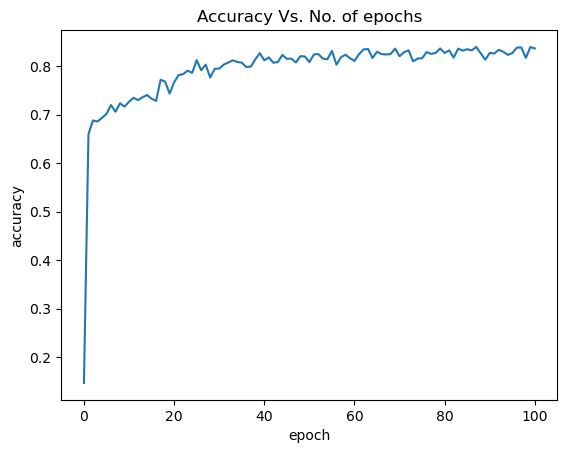

In [78]:
## Replace these values with your result
history = [result0] + history1# + history2 + history3# + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')
plt.savefig('/home/alex/Documents/NN_path_planning/nn/model/plot_Accuracy Vs. No. of epochs.png')

In [79]:
torch.save(model, '/home/alex/Documents/NN_path_planning/nn/model/model_v3.pth')

In [28]:
model_1 = torch.load('/home/alex/Documents/NN_path_planning/nn/model/model_v3.pth')

In [35]:
output = model_1.forward(custom_dataset[3000][0])
# _, pred = torch.max(output)
action = F.softmax(output).detach().numpy().argmax()
action

/tmp/ipykernel_501666/1757807647.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action = F.softmax(output).detach().numpy().argmax()


3